In [1]:
!pip install -r ../pycjs/requirements.txt

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
import sys

cur_dir = os.getcwd()
pkg_rootdir = os.path.dirname(cur_dir)  # *注意改为项目自定义包的根路径
# print(pkg_rootdir)
if pkg_rootdir not in sys.path:  # 解决ipynb引用上层路径中的模块时的ModuleNotFoundError问题
    sys.path.append(pkg_rootdir)
    print('-- Add root directory "{}" to system path.'.format(pkg_rootdir))

-- Add root directory "/home/node/notebook" to system path.


In [3]:
import copy
import pandas as pd

from node_vm2 import NodeVM

from pycjs.open_digger import vm_option_open_digger, get_export_module_open_digger
from pycjs.vm_context_manager import VMContext
from pycjs.metrics import MultiMime

/home/node/.local/lib/python3.8/site-packages/node_vm2/__init__.py:17: FutureWarning: node_vm2 is deprecated. Please use deno_vm instead.
  warnings.warn("node_vm2 is deprecated. Please use deno_vm instead.", FutureWarning)


In [4]:
from IPython.display import display

def displaymime(obj, to_format="to_markdown", mime_type="text/plain"):
    try:
        data = getattr(obj, to_format)()
    except AttributeError as e:
        data = str(obj)
        print(e)
    display({
        mime_type: data,
    }, raw=True)
    
valid_text_plain = ['to_csv', 'to_html', 'to_json', 'to_latex', 'to_markdown', 'to_numpy', 'to_string', 'to_xml']
print(f"valid_text_plain for dispalydf: {valid_text_plain}")

valid_text_plain for dispalydf: ['to_csv', 'to_html', 'to_json', 'to_latex', 'to_markdown', 'to_numpy', 'to_string', 'to_xml']


In [5]:
LEN_YEARS = 5
TOP_N_REPOS = 10

year = 2023
startYear = year - LEN_YEARS + 1
endYear = year
startMonth = 1
endMonth = 12
years = [i + startYear for i in range(LEN_YEARS)]

baseOptions = {
   "startYear": startYear,
   "endYear": endYear,
   "startMonth": startMonth,
   "endMonth": endMonth,
   "groupTimeRange": 'year',
   "order": 'DESC'
}

localOptions = {
   "limit": TOP_N_REPOS
}

options = copy.deepcopy(baseOptions)
options.update(localOptions)

In [6]:
vmc = VMContext(**vm_option_open_digger)

In [7]:
vmc.open()

In [8]:
vm = vmc.vm
export_module = get_export_module_open_digger(vm)
openDigger = export_module.openDigger

In [9]:
use_simple_name = True
def row_openrank_postprocess(row):
    years = [2019, 2020, 2021, 2022, 2023]
    return {
        "x": years,
        "y": row["openrank"],
        "name": row["name"]
    }

def row_activity_postprocess(row):
    years = [2019, 2020, 2021, 2022, 2023]
    return {
        "x": years,
        "y": row["activity"],
        "name": row["name"]
    }

# 2023中国开源年度报告

## 一. 总体宏观洞察

### 1.5 编程语言

#### 1.5.1 2023年开发者使用编程语言榜单

In [10]:
data = openDigger.driver.clickhouse.query(f"""
SELECT COUNT(DISTINCT actor_id) AS user_count, COUNT(DISTINCT repo_id) AS repo_count, repo_language  
FROM events 
WHERE repo_language != '' AND toYear(created_at) = '{year}' 
GROUP BY repo_language 
ORDER BY user_count DESC 
LIMIT 20;
""", {"format": "JSONEachRow"})
displaymime(pd.DataFrame(data))

|    |   user_count |   repo_count | repo_language    |
|---:|-------------:|-------------:|:-----------------|
|  0 |       765589 |      1806477 | JavaScript       |
|  1 |       629423 |       653025 | Python           |
|  2 |       564121 |       676364 | HTML             |
|  3 |       462729 |       886453 | TypeScript       |
|  4 |       368795 |       463660 | Java             |
|  5 |       190480 |       239187 | CSS              |
|  6 |       177905 |       135330 | C++              |
|  7 |       158159 |       180537 | C#               |
|  8 |       143433 |       165367 | Go               |
|  9 |       128186 |       272980 | PHP              |
| 10 |       122475 |       102708 | Jupyter Notebook |
| 11 |       122456 |       108209 | Shell            |
| 12 |       107918 |        80159 | C                |
| 13 |        69370 |        72778 | Rust             |
| 14 |        66857 |       374835 | Ruby             |
| 15 |        64307 |        62709 | Kotlin     

#### 1.5.2 2019-2023年开发者使用编程语言趋势

In [11]:
def repo_language_usecount_postprocess(row):
    return {
        "x": row["year"],
        "y": row["user_count"],
        "name": row["repo_language"][0]
    }

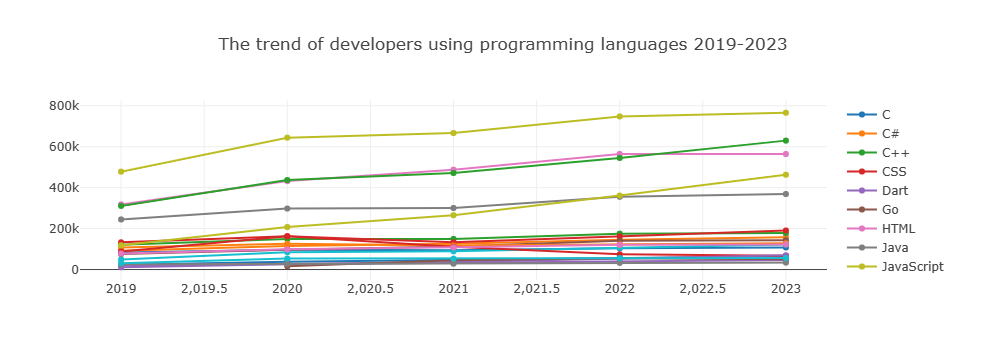

In [12]:
data = openDigger.driver.clickhouse.query(f"""
SELECT toYear(created_at) AS year, COUNT(DISTINCT actor_id) AS user_count, COUNT(DISTINCT repo_id) AS repo_count, repo_language
FROM events
WHERE toYear(created_at) IN ('{"', '".join(map(str, years))}') AND repo_language IN (
    SELECT repo_language FROM (
        SELECT COUNT(DISTINCT actor_id) AS user_count, COUNT(DISTINCT repo_id) AS repo_count, repo_language
        FROM events
        WHERE repo_language != '' AND toYear(created_at) = '{year}'
        GROUP BY repo_language
        ORDER BY user_count DESC
        LIMIT 20
    )
)
GROUP BY year, repo_language
ORDER BY year DESC, user_count DESC
""", {"format": "JSONEachRow"})
df_data = pd.DataFrame(data)
data_lang_dict_list = {k: v.to_dict("list") for k, v in df_data.groupby("repo_language")}
data_records = list(map(repo_language_usecount_postprocess, data_lang_dict_list.values()))
openDigger.render.plotly(
    data_records,
    {"title": f"The trend of developers using programming languages {startYear}-{year}", "xasix": {"type": "category"}},
    MultiMime()
)

## 3.技术领域项目分析

### 3.1 各领域OpenRank Top 10 榜单

### 大数据

In [13]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/big_data'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
displaymime(pd.DataFrame(data))

|    |        id | platform   | name                  | openrank   |
|---:|----------:|:-----------|:----------------------|:-----------|
|  0 |   7833168 | GitHub     | elastic/kibana        | [7601.04]  |
|  1 |  15111821 | GitHub     | grafana/grafana       | [7134.37]  |
|  2 |  60246359 | GitHub     | ClickHouse/ClickHouse | [4941.99]  |
|  3 | 283046497 | GitHub     | airbytehq/airbyte     | [4658.86]  |
|  4 |  99919302 | GitHub     | apache/doris          | [4307.26]  |
|  5 |    507775 | GitHub     | elastic/elasticsearch | [3729.39]  |
|  6 |  33884891 | GitHub     | apache/airflow        | [3642.9]   |
|  7 | 402945349 | GitHub     | StarRocks/starrocks   | [3194.56]  |
|  8 | 166515022 | GitHub     | trinodb/trino         | [2703.4]   |
|  9 |  17165658 | GitHub     | apache/spark          | [2654.02]  |

### 数据库

In [14]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/database'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
displaymime(pd.DataFrame(data))

|    |        id | platform   | name                  | openrank   |
|---:|----------:|:-----------|:----------------------|:-----------|
|  0 |  60246359 | GitHub     | ClickHouse/ClickHouse | [4941.99]  |
|  1 |  99919302 | GitHub     | apache/doris          | [4307.26]  |
|  2 |    507775 | GitHub     | elastic/elasticsearch | [3729.39]  |
|  3 |  16563587 | GitHub     | cockroachdb/cockroach | [3443.7]   |
|  4 | 402945349 | GitHub     | StarRocks/starrocks   | [3194.56]  |
|  5 | 166515022 | GitHub     | trinodb/trino         | [2703.4]   |
|  6 |  17165658 | GitHub     | apache/spark          | [2654.02]  |
|  7 |  41986369 | GitHub     | pingcap/tidb          | [2200.38]  |
|  8 | 208728772 | GitHub     | milvus-io/milvus      | [2001.11]  |
|  9 | 105944401 | GitHub     | yugabyte/yugabyte-db  | [1940.75]  |

### 操作系统

In [15]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/operating_system'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
displaymime(pd.DataFrame(data))

|    |        id | platform   | name                         | openrank   |
|---:|----------:|:-----------|:-----------------------------|:-----------|
|  0 | 160083795 | GitHub     | SerenityOS/serenity          | [2257.68]  |
|  1 | 105627846 | GitHub     | reactos/reactos              | [745.23]   |
|  2 |  24905898 | GitHub     | armbian/build                | [679.1]    |
|  3 | 179385712 | GitHub     | bottlerocket-os/bottlerocket | [462.12]   |
|  4 | 181022316 | GitHub     | unikraft/unikraft            | [340.81]   |
|  5 |  36428094 | GitHub     | tock/tock                    | [275.34]   |
|  6 |  61721573 | GitHub     | jens-maus/RaspberryMatic     | [176.58]   |
|  7 |  97989275 | GitHub     | theseus-os/Theseus           | [154.98]   |
|  8 |  71775220 | GitHub     | PDP-10/its                   | [69.1]     |
|  9 | 135060910 | GitHub     | hermit-os/kernel             | [68.58]    |

### 云原生

In [16]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/cloud_native'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
displaymime(pd.DataFrame(data))

|    |        id | platform   | name                   | openrank   |
|---:|----------:|:-----------|:-----------------------|:-----------|
|  0 |  15111821 | GitHub     | grafana/grafana        | [7134.37]  |
|  1 |  75821432 | GitHub     | llvm/llvm-project      | [7049.62]  |
|  2 |  20580498 | GitHub     | kubernetes/kubernetes  | [5374.14]  |
|  3 |  60246359 | GitHub     | ClickHouse/ClickHouse  | [4941.99]  |
|  4 |  48109239 | GitHub     | cilium/cilium          | [3215.42]  |
|  5 |   2310495 | GitHub     | ceph/ceph              | [3172.49]  |
|  6 |  11125589 | GitHub     | keycloak/keycloak      | [3095.56]  |
|  7 |  31558937 | GitHub     | gravitational/teleport | [3082.18]  |
|  8 |  65214191 | GitHub     | envoyproxy/envoy       | [2929.08]  |
|  9 | 236095576 | GitHub     | backstage/backstage    | [2903.39]  |

### 前端

In [17]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/frontend'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
displaymime(pd.DataFrame(data))

|    |        id | platform   | name                  | openrank   |
|---:|----------:|:-----------|:----------------------|:-----------|
|  0 |  31792824 | GitHub     | flutter/flutter       | [9367.81]  |
|  1 |  70107786 | GitHub     | vercel/next.js        | [6638.65]  |
|  2 | 275993885 | GitHub     | appsmithorg/appsmith  | [3474.07]  |
|  3 |  71995937 | GitHub     | nuxt/nuxt             | [3387.23]  |
|  4 |  29028775 | GitHub     | facebook/react-native | [3260.55]  |
|  5 |  34526884 | GitHub     | ant-design/ant-design | [3053.25]  |
|  6 |  27193779 | GitHub     | nodejs/node           | [2736.37]  |
|  7 |  24195339 | GitHub     | angular/angular       | [2273.82]  |
|  8 |   9384267 | GitHub     | electron/electron     | [1773.31]  |
|  9 | 133442384 | GitHub     | denoland/deno         | [1654.01]  |

### 人工智能

In [18]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/ai'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
displaymime(pd.DataFrame(data))

|    |        id | platform   | name                                 | openrank   |
|---:|----------:|:-----------|:-------------------------------------|:-----------|
|  0 |  65600975 | GitHub     | pytorch/pytorch                      | [10182.45] |
|  1 | 552661142 | GitHub     | langchain-ai/langchain               | [6080.25]  |
|  2 |  65711522 | GitHub     | PaddlePaddle/Paddle                  | [5408.62]  |
|  3 | 155220641 | GitHub     | huggingface/transformers             | [4422.84]  |
|  4 | 527591471 | GitHub     | AUTOMATIC1111/stable-diffusion-webui | [3881.6]   |
|  5 | 153097643 | GitHub     | openvinotoolkit/openvino             | [3857.31]  |
|  6 | 156939672 | GitHub     | microsoft/onnxruntime                | [3006.75]  |
|  7 |  45717250 | GitHub     | tensorflow/tensorflow                | [2723.26]  |
|  8 | 614765452 | GitHub     | Significant-Gravitas/AutoGPT         | [2664.85]  |
|  9 | 612354784 | GitHub     | ggerganov/llama.cpp                  | [2339

### 3.2 各领域 OpenRank Top 10项目近五年变化趋势

In [19]:
def processTechFieldRepoOpenrank(label, title):
    data = openDigger.index.openrank.getRepoOpenrank(
        dict(**baseOptions, 
             **{"labelIntersect": [label], "limit": 10}
            )
    )
    data_records = pd.DataFrame(data).apply(row_openrank_postprocess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_records,
        {"title": f"Top 10 OpenRank repositories of {title} 2019-2023"},
        MultiMime()
    )

In [20]:
def processTechFieldRepoActivity(label, title):
    data = openDigger.index.activity.getRepoActivity(
        dict(**baseOptions, 
             **{"labelIntersect": [label], "limit": 10}
            )
    )
    data_records = pd.DataFrame(data).apply(row_activity_postprocess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_records, 
        {"title": f"Top 10 Activity repositories of {title} 2019-2023"},
        MultiMime()
    )

### 大数据

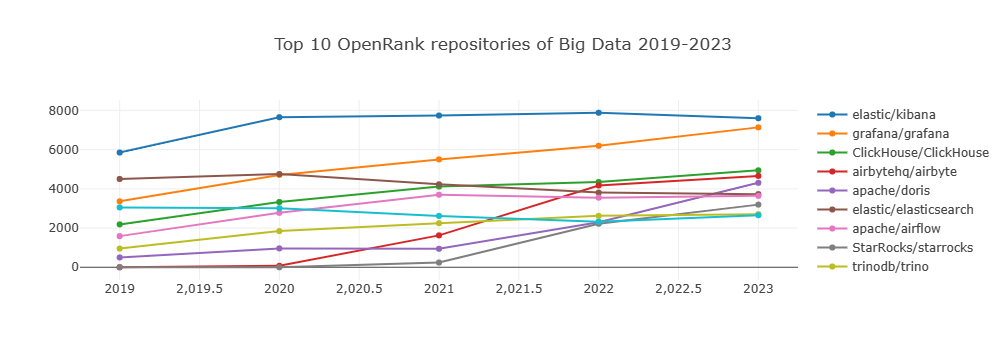

In [21]:
processTechFieldRepoOpenrank(':technology/big_data', 'Big Data');

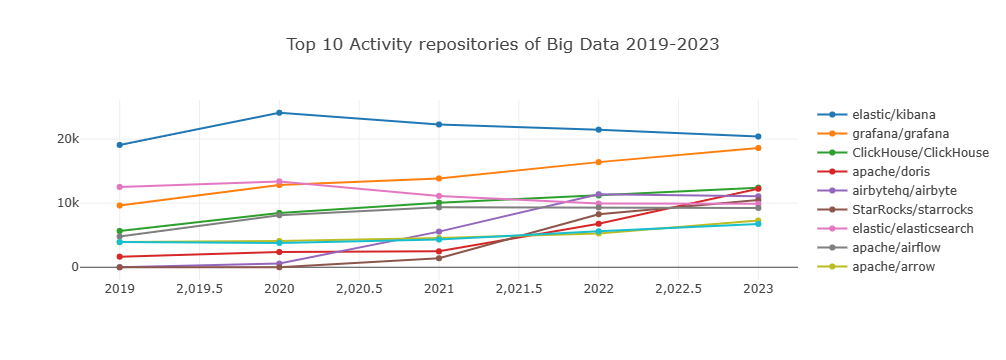

In [22]:
processTechFieldRepoActivity(':technology/big_data', 'Big Data')

### 数据库

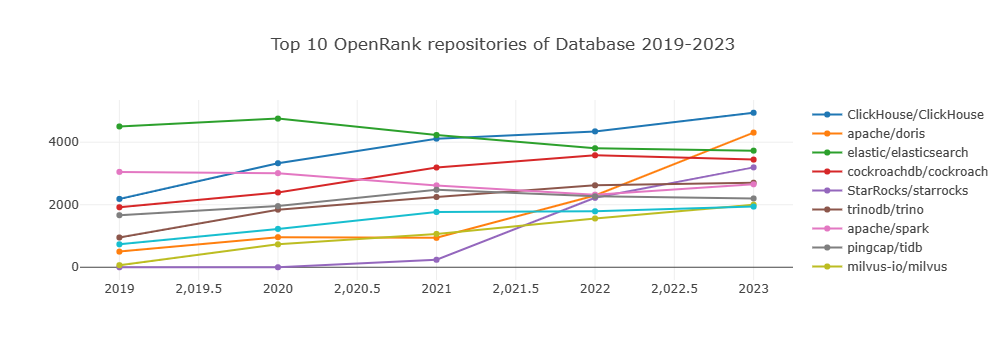

In [23]:
processTechFieldRepoOpenrank(':technology/database', 'Database');

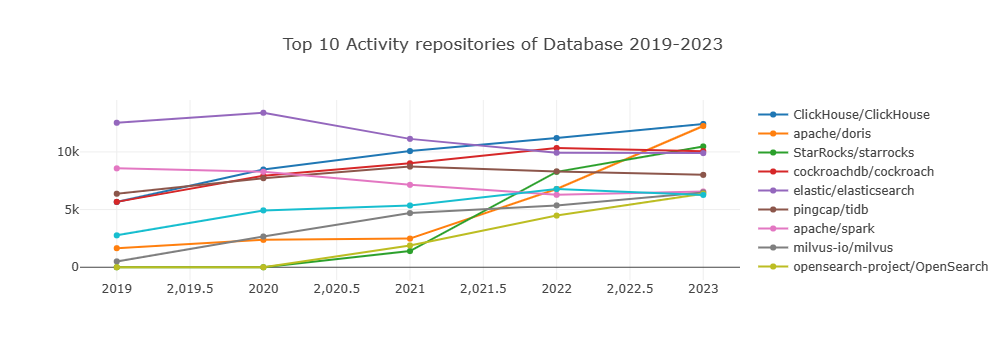

In [24]:
processTechFieldRepoActivity(':technology/database', 'Database');

### 操作系统

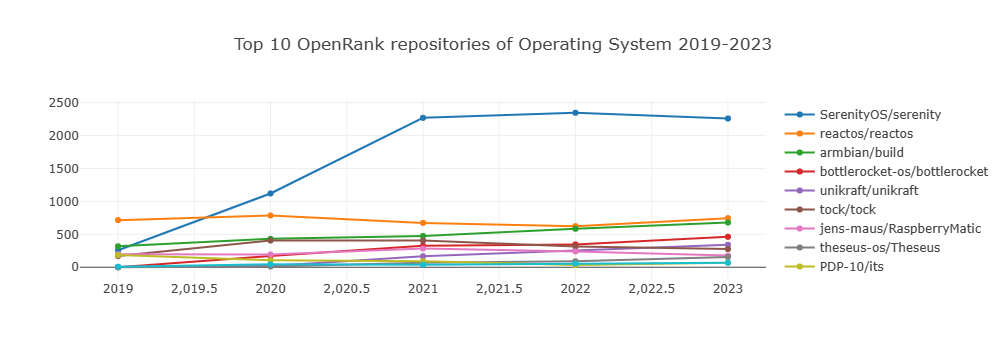

In [25]:
processTechFieldRepoOpenrank(':technology/operating_system', 'Operating System');

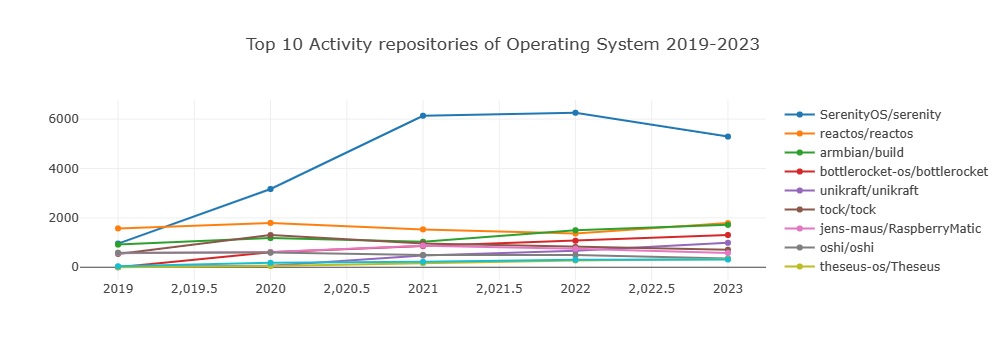

In [26]:
processTechFieldRepoActivity(':technology/operating_system', 'Operating System');

### 云原生

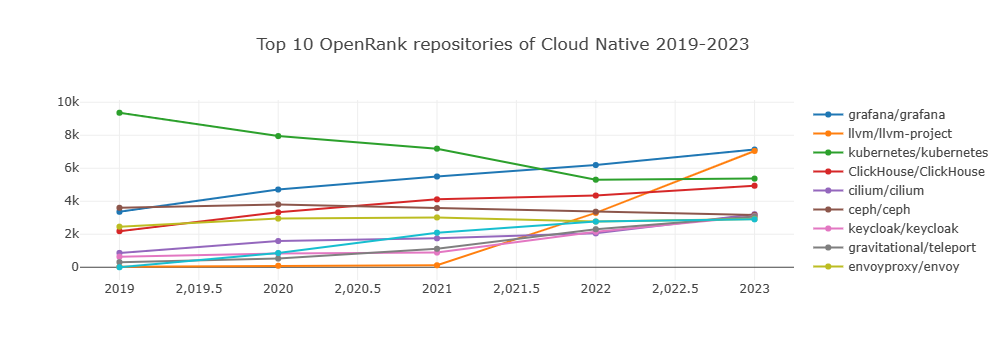

In [27]:
processTechFieldRepoOpenrank(':technology/cloud_native', 'Cloud Native');

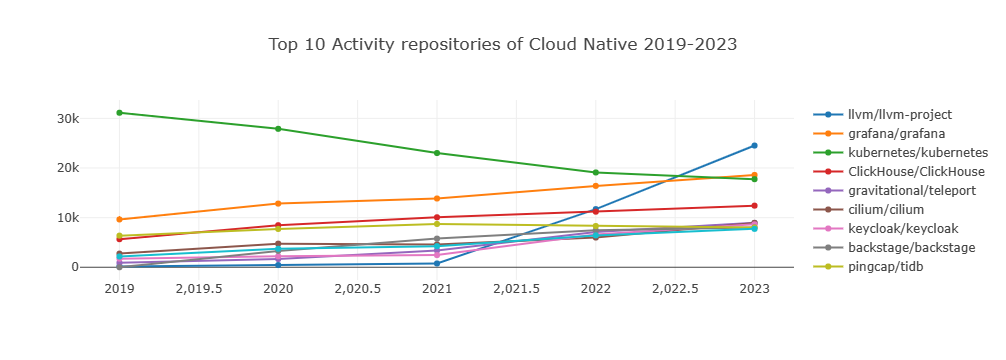

In [28]:
processTechFieldRepoActivity(':technology/cloud_native', 'Cloud Native');

### 前端

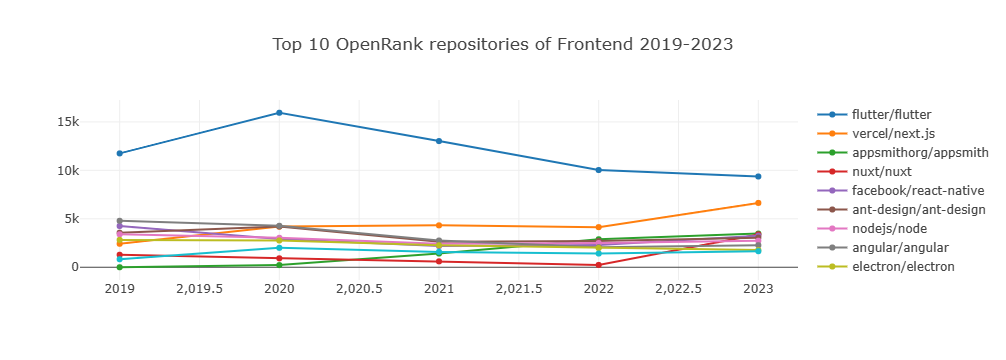

In [29]:
processTechFieldRepoOpenrank(':technology/frontend', 'Frontend');

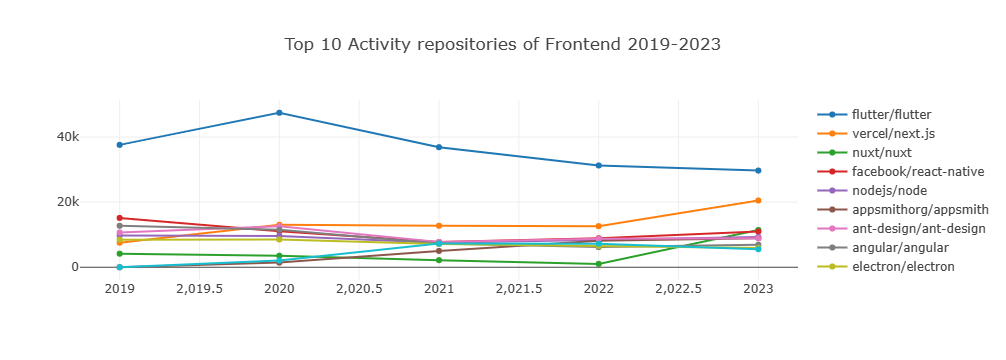

In [30]:
processTechFieldRepoActivity(':technology/frontend', 'Frontend');

### 人工智能

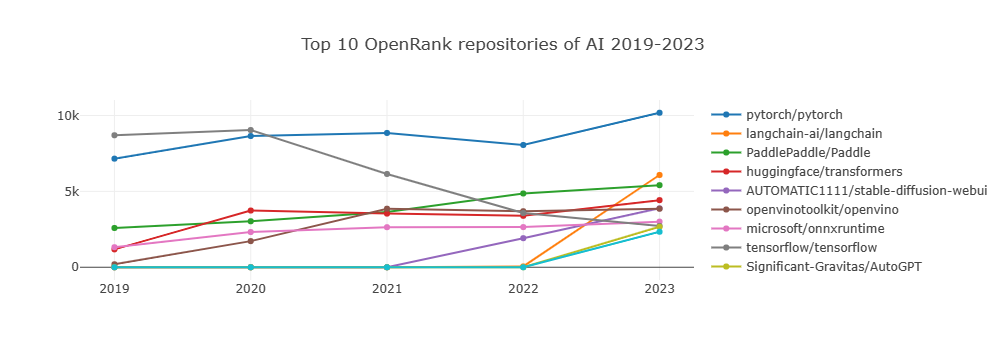

In [31]:
processTechFieldRepoOpenrank(':technology/ai', 'AI');

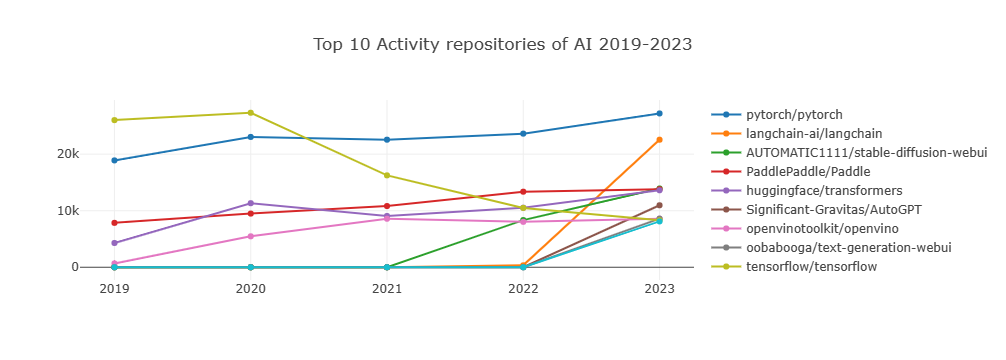

In [32]:
processTechFieldRepoActivity(':technology/ai', 'AI');

### 3.3 各子领域近5年变化趋势

In [33]:
def processTechSubfieldsRepoOpenrank(options, title_meta, use_simple_name=True):
    data = openDigger.index.openrank.getRepoOpenrank(options)
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology'), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_records = data_df_formated.apply(row_openrank_postprocess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_records,
        title_meta,
        MultiMime()
    )

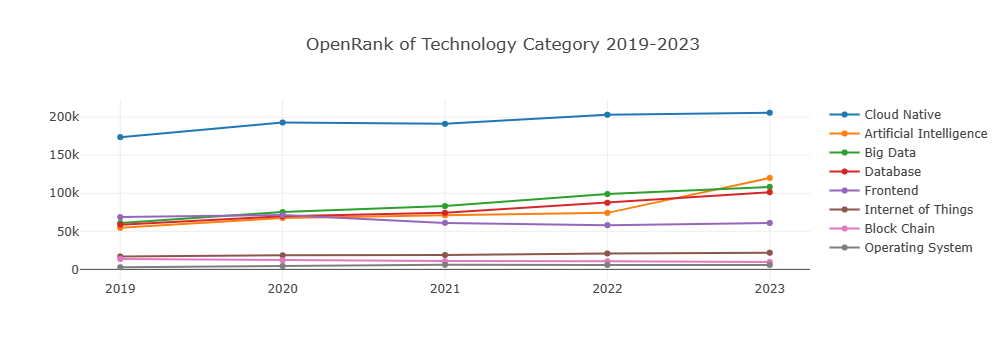

In [34]:
processTechSubfieldsRepoOpenrank({
    "labelUnion": ['Tech-0'],  # ':technology' is invalid because there is no such a top level label for the technology directory. 'Tech-0' can be used to represent the first level technical field label
    "startYear": 2019, "endYear": 2023, "endMonth": 12,
    "groupBy": 'Tech-0',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
}, {"title": "OpenRank of Technology Category 2019-2023", "xaxis": { "type": 'category' }})

In [35]:
def processTechSubfieldsRepoActivity(options, title_meta, use_simple_name=True):
    data = openDigger.index.activity.getRepoActivity(options)
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology'), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_records = data_df_formated.apply(row_activity_postprocess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_records,
        title_meta,
        MultiMime()
    )

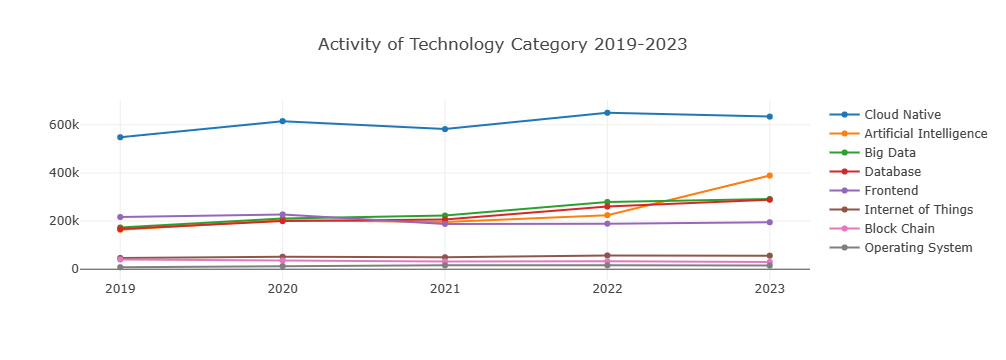

In [36]:
processTechSubfieldsRepoActivity({
    "labelUnion": ['Tech-0'],
    "startYear": 2019, "endYear": 2023, "endMonth": 12,
    "groupBy": 'Tech-0',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
}, {"title": "Activity of Technology Category 2019-2023", "xaxis": { "type": 'category' }})

## 6.开源项目洞察

### 6.1 不同项目类型数量比例

![jupyter](./img/repo_count.png)

1. Libraries and Frameworks占比较高： 这一类项目占比约31.36%。这可能意味着在开源社区中，对于构建和提供工具、框架以及库的需求非常高。这些项目对于其他开发者来说是重要的基础资源。
2. Application Software也有相当份额： 这类项目占比约24.34%。这显示了开发者们不仅对于工具和基础设施感兴趣，也有很多人专注于构建实际的应用程序和软件产品。
3. Non Software类占比较大： 这类项目占比约23.17%。这表明GitHub社区中还存在着大量非软件类项目，可能涉及文档、教育、艺术、硬件或其他非编程相关领域的创作和贡献。
4. Software Tools和System Software占比较少： 这两类项目占比合计约21.13%。可能因为这些项目相对特定或者是较为专业化的工具和系统软件，因此数量较少。

### 6.2 不同项目类型 OpenRank 加总比例

In [37]:
def df_openrank_postprocess(df):
    return [{
        "labels": df["name"].values.tolist(),
        "values": df["openrank"].apply(lambda x: x[0]).values.tolist(),
        "type": 'pie',
        "name": 'times',
        "textinfo": "label+percent"
    }]

def processApplyRatioRepoOpenrank(options, title_meta):
    data = openDigger.index.openrank.getRepoOpenrank(options)
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':application_domain'), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_records = df_openrank_postprocess(data_df_formated)
    openDigger.render.plotly(
        data_records,
        title_meta,
        MultiMime()
    )

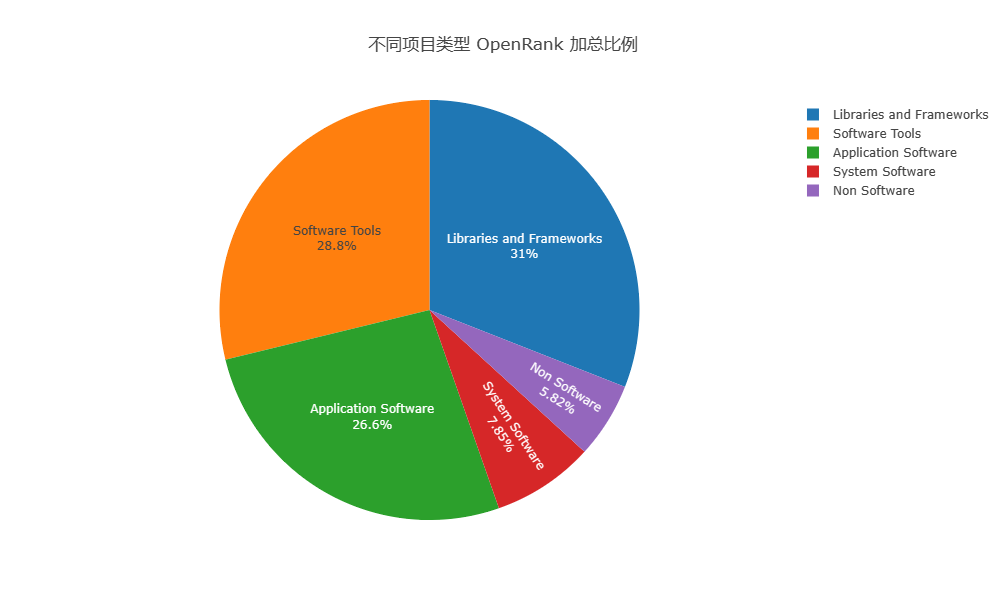

In [38]:
processApplyRatioRepoOpenrank({
    "labelUnion": [':application_domain'],
    "startYear": 2023, "endYear": 2023, "endMonth": 12,
    "groupBy": 'Domain-0',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
}, {
    "title": '不同项目类型 OpenRank 加总比例',
    "xaxis": {"type": 'category'},
    "height": 600,
    # "width":1050,
})

### 6.3 不同项目类型 近5年 OpenRank 变化趋势

In [39]:
def processApplySubfieldsRepoOpenrank(options, title_meta, use_simple_name=True):
    data = openDigger.index.openrank.getRepoOpenrank(options)
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':application_domain'), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_records = data_df_formated.apply(row_openrank_postprocess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_records,
        title_meta,
        MultiMime()
    )

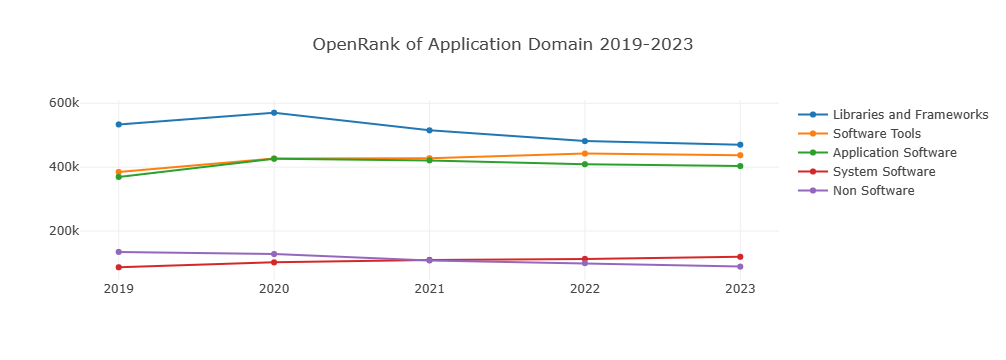

In [40]:
processApplySubfieldsRepoOpenrank({
    "labelUnion": [':application_domain'],
    "startYear": 2019, "endYear": 2023, "endMonth": 12,
    "groupBy": 'Domain-0',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
}, {"title": "OpenRank of Application Domain 2019-2023", "xaxis": { "type": 'category' }})

### 6.4 数据库领域项目分析

### 数据库领域项目 OpenRank Top 10

数据库领域 2023 年度 OpenRank 指标 Top 10 的项目排行榜

In [41]:
data = openDigger.index.openrank.getRepoOpenrank(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'], "startYear": year, "endYear": year, "limit": 10}
))
displaymime(pd.DataFrame(data))

|    |        id | platform   | name                  | openrank   |
|---:|----------:|:-----------|:----------------------|:-----------|
|  0 |  60246359 | GitHub     | ClickHouse/ClickHouse | [4941.99]  |
|  1 |  99919302 | GitHub     | apache/doris          | [4307.26]  |
|  2 |    507775 | GitHub     | elastic/elasticsearch | [3729.39]  |
|  3 |  16563587 | GitHub     | cockroachdb/cockroach | [3443.7]   |
|  4 | 402945349 | GitHub     | StarRocks/starrocks   | [3194.56]  |
|  5 | 166515022 | GitHub     | trinodb/trino         | [2703.4]   |
|  6 |  17165658 | GitHub     | apache/spark          | [2654.02]  |
|  7 |  41986369 | GitHub     | pingcap/tidb          | [2200.38]  |
|  8 | 208728772 | GitHub     | milvus-io/milvus      | [2001.11]  |
|  9 | 105944401 | GitHub     | yugabyte/yugabyte-db  | [1940.75]  |

### 数据库领域项目 活跃度 Top 10

数据库领域 2023 年度 Activity 指标 Top 10 的项目排行榜

In [42]:
data = openDigger.index.activity.getRepoActivity(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'], "startYear": year, "endYear": year, "limit": 10}
))
displaymime(pd.DataFrame(data))

|    |        id | platform   | name                          | activity   | participants   | issue_comment   | open_issue   | open_pull   | review_comment   | merged_pull   |
|---:|----------:|:-----------|:------------------------------|:-----------|:---------------|:----------------|:-------------|:------------|:-----------------|:--------------|
|  0 |  60246359 | GitHub     | ClickHouse/ClickHouse         | [12418.45] | ['4439']       | ['27230']       | ['3750']     | ['8314']    | ['11573']        | ['7361']      |
|  1 |  99919302 | GitHub     | apache/doris                  | [12244.03] | ['2750']       | ['82001']       | ['1475']     | ['10836']   | ['15234']        | ['9065']      |
|  2 | 402945349 | GitHub     | StarRocks/starrocks           | [10471.99] | ['1925']       | ['82147']       | ['2071']     | ['18232']   | ['13352']        | ['14343']     |
|  3 |  16563587 | GitHub     | cockroachdb/cockroach         | [10065.19] | ['1829']       | ['80061']       | ['10160'

### 数据库领域 近5年 OpenRank和Activity 变化趋势

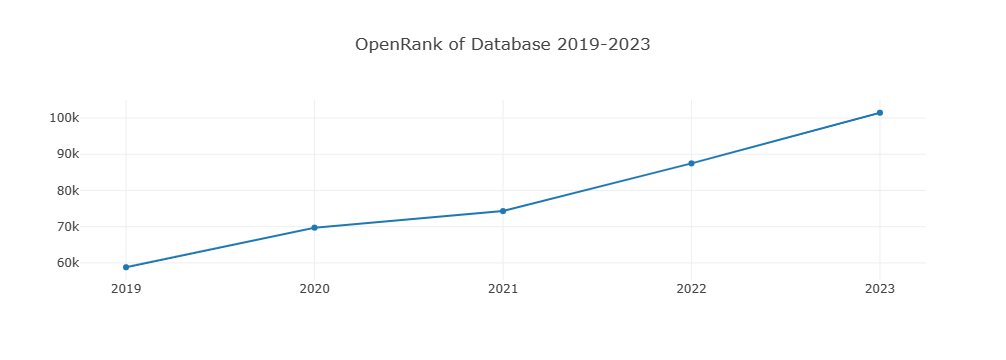

In [43]:
data = openDigger.index.openrank.getRepoOpenrank(dict(
    baseOptions, 
    **{"labelUnion": ['Tech-0'],
    "groupBy": 'Tech-0',
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
data_records = data_df_filtered.apply(row_openrank_postprocess, axis=1).values.tolist()
title_meta = {"title": "OpenRank of Database 2019-2023", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

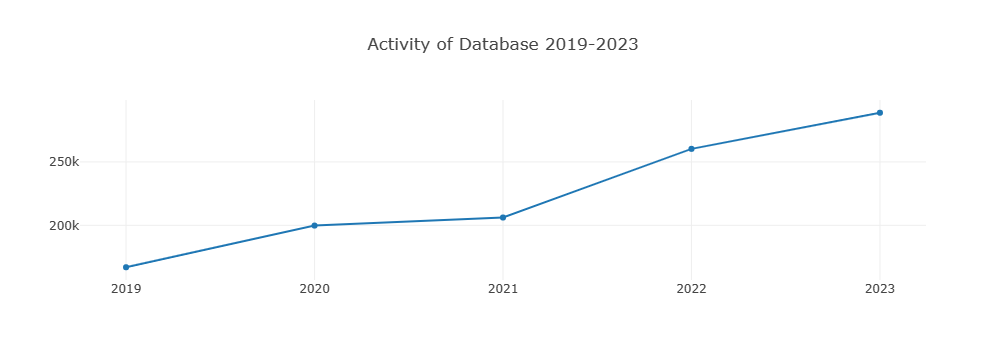

In [44]:
data = openDigger.index.activity.getRepoActivity(dict(
    baseOptions, 
    **{"labelUnion": ['Tech-0'],
    "groupBy": 'Tech-0',
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
data_records = data_df_filtered.apply(row_activity_postprocess, axis=1).values.tolist()
title_meta = {"title": "Activity of Database 2019-2023", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

### 数据库领域各子领域 2023年 OpenRank 榜单

In [45]:
use_simple_name = True

In [46]:
data = openDigger.index.openrank.getRepoOpenrank(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'], 
    "startYear": year, "endYear": year, 
    "groupBy": 'Tech-1', 
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
data_df_formated = data_df_filtered.copy()
if use_simple_name:
    data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
displaymime(data_df_formated)

|    | id                                   | platform   | name            | openrank   |
|---:|:-------------------------------------|:-----------|:----------------|:-----------|
|  0 | :technology/database/relational      | All        | Relational      | [58092.36] |
|  3 | :technology/database/key_value       | All        | Key-value       | [21834.08] |
|  4 | :technology/database/document        | All        | Document        | [17264.93] |
|  5 | :technology/database/search_engine   | All        | Search Engine   | [8093.77]  |
|  6 | :technology/database/wide_column     | All        | Wide Column     | [7896.43]  |
|  7 | :technology/database/time_series     | All        | Time Series     | [7813.54]  |
|  9 | :technology/database/graph           | All        | Graph           | [5196.52]  |
| 10 | :technology/database/vector          | All        | Vector          | [4965.41]  |
| 12 | :technology/database/object_oriented | All        | Object Oriented | [3104.07]  |
| 16 | :te

### 数据库领域各子领域 2023年 Activity 榜单

In [47]:
data = openDigger.index.activity.getRepoActivity(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'], 
    "startYear": year, "endYear": year, 
    "groupBy": 'Tech-1', 
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
data_df_formated = data_df_filtered.copy()
if use_simple_name:
    data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
displaymime(data_df_formated)

|    | id                                   | platform   | name            | activity    | participants   | issue_comment   | open_issue   | open_pull   | review_comment   | merged_pull   |
|---:|:-------------------------------------|:-----------|:----------------|:------------|:---------------|:----------------|:-------------|:------------|:-----------------|:--------------|
|  0 | :technology/database/relational      | All        | Relational      | [161025.44] | ['46084']      | ['584328']      | ['49257']    | ['118340']  | ['224215']       | ['90948']     |
|  3 | :technology/database/key_value       | All        | Key-value       | [62501.64]  | ['19782']      | ['249385']      | ['15526']    | ['34079']   | ['95487']        | ['24839']     |
|  4 | :technology/database/document        | All        | Document        | [49400.11]  | ['15472']      | ['108165']      | ['10553']    | ['33308']   | ['67272']        | ['28452']     |
|  5 | :technology/database/search_engine   | All 

### 数据库领域各子领域 近5年 OpenRank 变化趋势

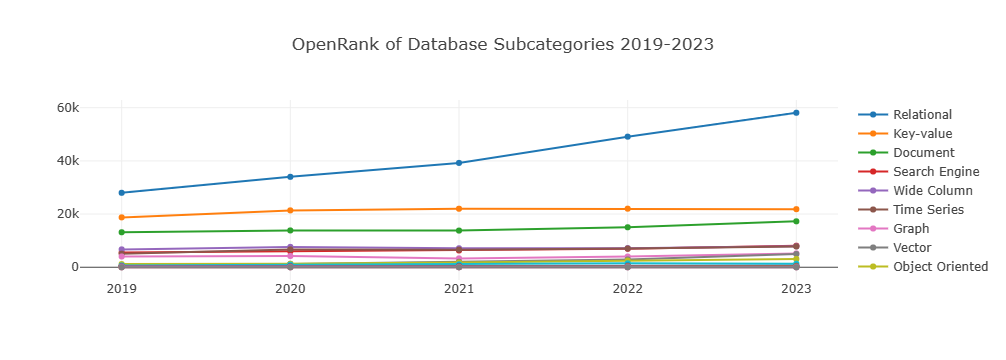

In [48]:
data = openDigger.index.openrank.getRepoOpenrank(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'],
    "groupBy": 'Tech-1',
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
data_df_formated = data_df_filtered.copy()
if use_simple_name:
    data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
data_records = data_df_formated.apply(row_openrank_postprocess, axis=1).values.tolist()
title_meta = {"title": "OpenRank of Database Subcategories 2019-2023", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

In [49]:
def openrank_rank_postporcess(row):
    return {
        "x": [2019, 2020, 2021, 2022, 2023],
        "y": row["values"],
        "name": row["name"],
        "type": 'scatter'
    }
def processSubfieldRankRepoOpenrank(options, title):
    data = openDigger.index.openrank.getRepoOpenrank(dict(
        baseOptions, 
        **options
    ))
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["name"].startswith('Database - '), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_records = pd.DataFrame(data_df_formated).to_dict('records')
    data_periodranks = openDigger.getRank(data_records, lambda x: x["name"], lambda x: x["openrank"])
    data_periodranks_records = pd.DataFrame(data_periodranks).apply(openrank_rank_postporcess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_periodranks_records, 
        {
            "title": f"OpenRank of {title} Subcategories Ranking {startYear}-{year}", 
            "xaxis": { "type": 'category' }, 
            "yaxis": { "autorange": 'reversed', "dtick": 1 } 
        }, 
        MultiMime()
    )

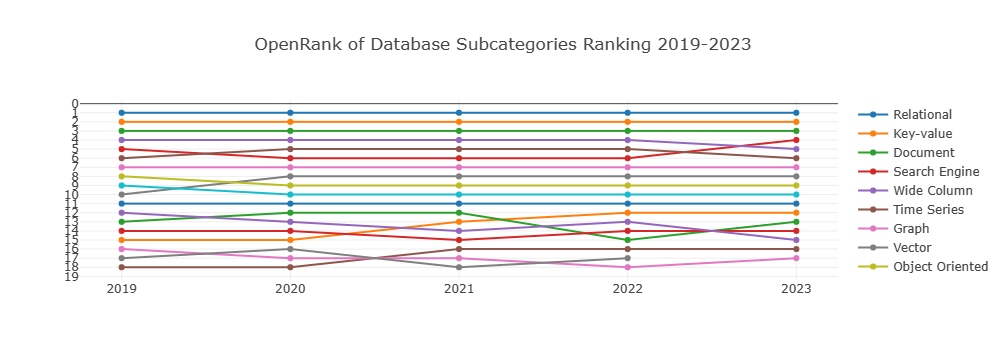

In [50]:
processSubfieldRankRepoOpenrank({
    "labelUnion": [':technology/database'],
    "groupBy": 'Tech-1',
    "limit": -1}, "Database")

### 数据库领域各子领域 近5年 Activity 变化趋势

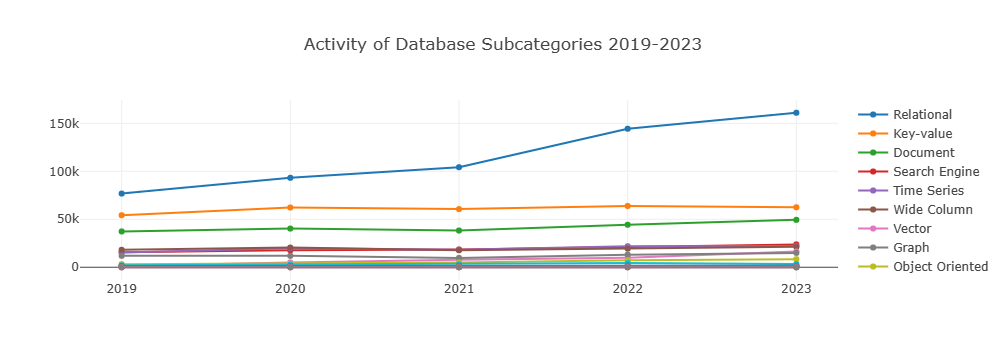

In [51]:
data = openDigger.index.activity.getRepoActivity(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'],
    "groupBy": 'Tech-1',
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
data_df_formated = data_df_filtered.copy()
if use_simple_name:
    data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
data_records = data_df_formated.apply(row_activity_postprocess, axis=1).values.tolist()
title_meta = {"title": "Activity of Database Subcategories 2019-2023", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

In [52]:
def activity_rank_postporcess(row):
    return {
        "x": [2019, 2020, 2021, 2022, 2023],
        "y": row["values"],
        "name": row["name"],
        "type": 'scatter'
    }
def processSubfieldRankRepoActivity(options, title):
    data = openDigger.index.activity.getRepoActivity(dict(
        baseOptions, 
        **options
    ))
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["name"].startswith('Database - '), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_records = pd.DataFrame(data_df_formated).to_dict('records')
    data_periodranks = openDigger.getRank(data_records, lambda x: x["name"], lambda x: x["activity"])
    data_periodranks_records = pd.DataFrame(data_periodranks).apply(activity_rank_postporcess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_periodranks_records, 
        {
            "title": f"Activity of {title} Subcategories Ranking {startYear}-{year}", 
            "xaxis": { "type": 'category' }, 
            "yaxis": { "autorange": 'reversed', "dtick": 1 } 
        }, 
        MultiMime()
    )

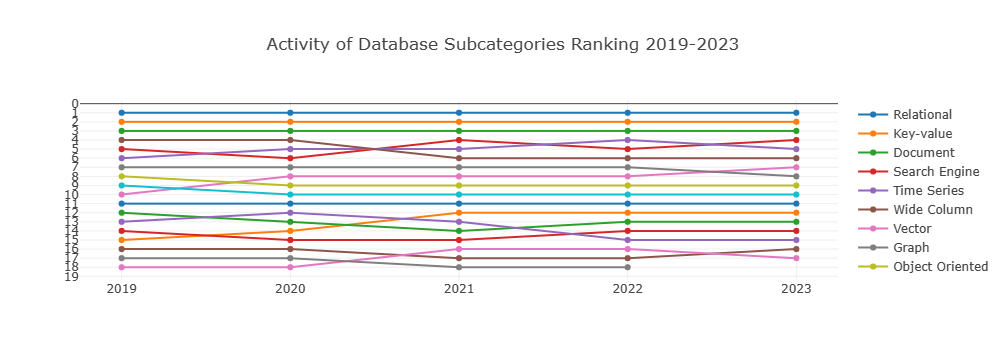

In [53]:
processSubfieldRankRepoActivity({
    "labelUnion": [':technology/database'],
    "groupBy": 'Tech-1',
    "limit": -1}, "Database")

### 开源数据库 OpenRank Top30 项目时区打点分布图

此处将根据开源数据库项目 OpenRank Top 30 在 2023 全年中的事件按事件分布情况绘制打孔图，从而可以观察项目的工作时间分布情况。

In [54]:
import json
import math

data = openDigger.index.openrank.getRepoOpenrank(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'], 
    "startYear": year, "endYear": year,
    "limit": 30,
    }
))
data_df = pd.DataFrame(data)
ids = data_df["id"].values.tolist()
sql = f"""
SELECT repo_id, argMax(name, time) AS name, groupArray(count) AS data
FROM
(SELECT repo_id, argMax(repo_name, created_at) AS name, MAX(created_at) AS time, toDayOfWeek(created_at) AS weekday, toHour(created_at) AS hour, COUNT() AS count
FROM events
WHERE toYear(created_at)=2023 AND repo_id IN ('{"','".join(ids)}')
GROUP BY repo_id, weekday, hour
ORDER BY weekday, hour)
GROUP BY repo_id
"""
data_time_distribution = openDigger.driver.clickhouse.query(sql)
for d in data_time_distribution:
    maxCount = max(list(map(float,d[2])))
    d_ceiled = [math.ceil(int(c)*10/maxCount) for c in d[2]]
    print(f"项目 {d[1]} 的工作时间分布链接为：https://oss.x-lab.info/open_digger/assets/working_hour_distribution.svg?data={json.dumps(d_ceiled, separators=(',', ':'))}");


项目 apache/pinot 的工作时间分布链接为：https://oss.x-lab.info/open_digger/assets/working_hour_distribution.svg?data=[2,3,2,2,2,2,2,4,2,2,2,2,2,2,3,3,4,6,5,6,5,5,6,6,5,5,3,4,3,4,4,3,3,2,2,2,2,2,3,3,5,7,8,6,7,9,10,9,7,5,4,3,4,5,6,5,4,3,2,3,2,2,3,4,4,7,7,7,6,7,10,7,7,5,5,3,4,3,4,3,3,3,2,3,2,2,3,4,5,6,9,7,6,6,5,7,6,4,3,3,3,3,4,5,3,2,2,3,2,2,3,3,5,5,6,6,6,6,8,7,7,4,3,2,2,2,2,2,2,2,1,1,1,1,1,1,1,2,2,2,2,1,2,1,1,2,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,1,1,2,2]
项目 apple/foundationdb 的工作时间分布链接为：https://oss.x-lab.info/open_digger/assets/working_hour_distribution.svg?data=[1,1,1,1,2,2,2,1,1,1,1,1,1,2,2,3,5,8,8,9,8,8,9,8,6,6,4,3,3,2,2,2,2,1,1,1,1,1,2,3,6,8,9,8,9,9,10,9,7,5,4,3,3,3,3,2,2,1,1,1,1,2,2,3,5,7,8,8,9,9,10,9,7,6,4,3,4,3,2,2,1,1,1,1,1,1,2,2,5,7,8,10,9,10,10,9,7,4,3,3,3,3,2,2,2,1,1,1,1,1,2,3,5,8,8,8,9,10,9,8,7,4,3,3,2,2,2,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
项目 apache/shardingsphere 的工作时间分布链接为：https://oss.x-lab.info/open_digger/assets/working_hour_distributio

### 6.5 生成式AI领域项目分析

### 生成式AI领域项目 OpenRank Top 10

此处给出数个生成式AI领域 2023 年度 OpenRank 指标 Top 10 项目及其自 2018 年起的 OpenRank 变化趋势。*

In [55]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/ai/generative_ai'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
displaymime(pd.DataFrame(data))

|    |        id | platform   | name                                 | openrank   |
|---:|----------:|:-----------|:-------------------------------------|:-----------|
|  0 | 552661142 | GitHub     | langchain-ai/langchain               | [6080.25]  |
|  1 | 155220641 | GitHub     | huggingface/transformers             | [4422.84]  |
|  2 | 527591471 | GitHub     | AUTOMATIC1111/stable-diffusion-webui | [3881.6]   |
|  3 | 614765452 | GitHub     | Torantulino/Auto-GPT                 | [2664.85]  |
|  4 | 612354784 | GitHub     | ggerganov/llama.cpp                  | [2339.8]   |
|  5 | 580642043 | GitHub     | oobabooga/text-generation-webui      | [2242.5]   |
|  6 | 208728772 | GitHub     | milvus-io/milvus                     | [2001.11]  |
|  7 | 560704231 | GitHub     | run-llama/llama_index                | [1913.01]  |
|  8 | 388946490 | GitHub     | facebookincubator/velox              | [1589.53]  |
|  9 | 525592995 | GitHub     | invoke-ai/InvokeAI                   | [1571

### 生成式AI领域项目 活跃度 Top 10

In [56]:
data = openDigger.index.activity.getRepoActivity({
    "labelUnion": [':technology/ai/generative_ai'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
displaymime(pd.DataFrame(data))

|    |        id | platform   | name                                 | activity   | participants   | issue_comment   | open_issue   | open_pull   | review_comment   | merged_pull   |
|---:|----------:|:-----------|:-------------------------------------|:-----------|:---------------|:----------------|:-------------|:------------|:-----------------|:--------------|
|  0 | 552661142 | GitHub     | langchain-ai/langchain               | [22563.04] | ['13068']      | ['32196']       | ['4851']     | ['7732']    | ['6693']         | ['5978']      |
|  1 | 527591471 | GitHub     | AUTOMATIC1111/stable-diffusion-webui | [13933.03] | ['11064']      | ['22481']       | ['3444']     | ['1229']    | ['192']          | ['828']       |
|  2 | 155220641 | GitHub     | huggingface/transformers             | [13618.11] | ['7297']       | ['27834']       | ['2860']     | ['3598']    | ['15937']        | ['2670']      |
|  3 | 614765452 | GitHub     | Significant-Gravitas/AutoGPT         | [10961.81] | [

### 生成式AI领域 OpenRank Top 10 项目近5年增长趋势

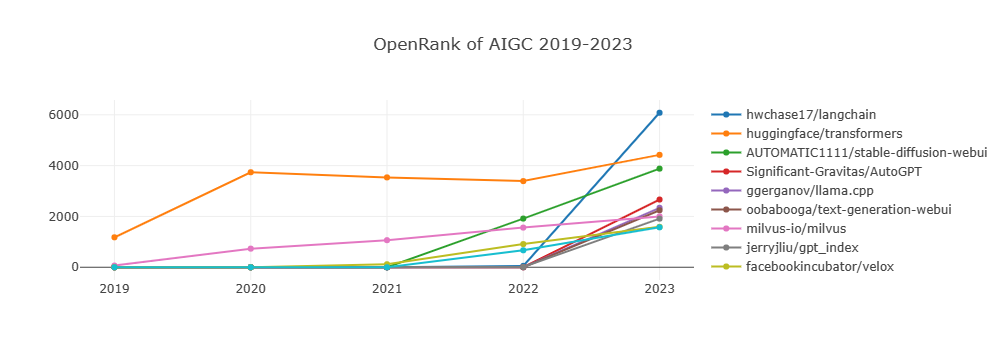

In [57]:
data = openDigger.index.openrank.getRepoOpenrank({
    "startYear": startYear, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "order": 'DESC', "labelIntersect": [':technology/ai/generative_ai'], "limit": 10
})

data_df = pd.DataFrame(data)
data_records = data_df.apply(row_openrank_postprocess, axis=1).values.tolist()
title_meta = {"title": "OpenRank of AIGC 2019-2023", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

### 生成式AI领域 活跃度 Top 10 项目近5年增长趋势

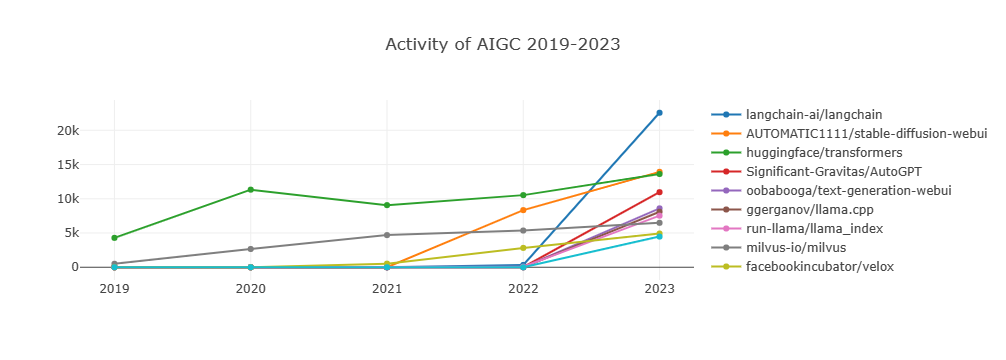

In [58]:
data = openDigger.index.activity.getRepoActivity({
    "startYear": startYear, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "order": 'DESC', "labelIntersect": [':technology/ai/generative_ai'], "limit": 10
})
data_df = pd.DataFrame(data)
data_records = data_df.apply(row_activity_postprocess, axis=1).values.tolist()
title_meta = {"title": "Activity of AIGC 2019-2023", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

### 生成式AI各子领域近5年增长趋势

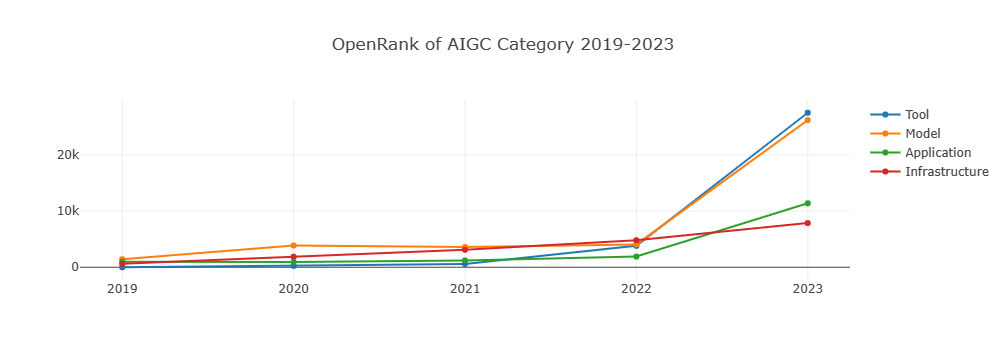

In [59]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/ai/generative_ai'],
    "startYear": 2019, "endYear": 2023, "endMonth": 12,
    "groupBy": 'Tech-2',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
})
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/ai/generative_ai'), axis=1)]
data_df_formated = data_df_filtered.copy()
if use_simple_name:
    data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
data_records = data_df_formated.apply(row_openrank_postprocess, axis=1).values.tolist()
title_meta = {"title": "OpenRank of AIGC Category 2019-2023", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

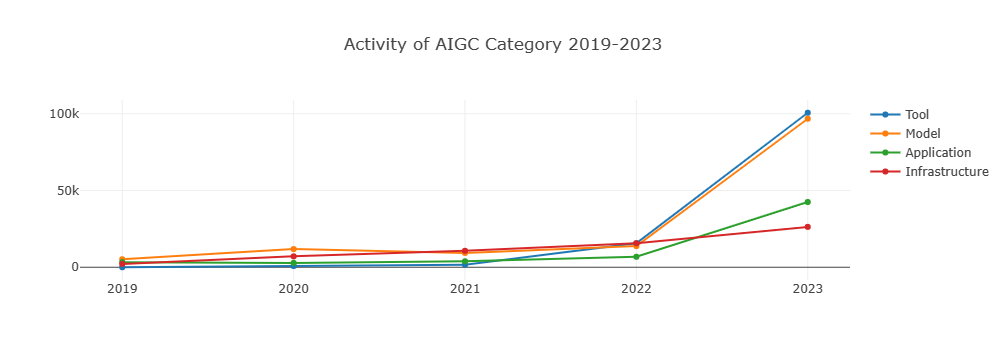

In [60]:
data = openDigger.index.activity.getRepoActivity({
    "labelUnion": [':technology/ai/generative_ai'],
    "startYear": 2019, "endYear": 2023, "endMonth": 12,
    "groupBy": 'Tech-2',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
})

data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/ai/generative_ai'), axis=1)]
data_df_formated = data_df_filtered.copy()
if use_simple_name:
    data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
data_records = data_df_formated.apply(row_activity_postprocess, axis=1).values.tolist()
title_meta = {"title": "Activity of AIGC Category 2019-2023", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

### 6.6 项目 Topic 分析

![jupyter](./img/topic_top10.png)

In [61]:
vmc.close()